In [228]:
using DataFrames,PythonPlot,StatsBase,Random,Distributions,CSV,DSP
PythonPlot.svg(true)
include("model.jl")
include("formulas.jl")

FIG_PATH = "/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth"

"/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth"

In [229]:
data= CSV.read("./output/sho_data_cells_1d.csv",DataFrame);
data
ω0range = data.ω0 |> unique |> sort;
ηrange = data.η |> unique |> sort;
nuxrange = data.nux |> unique |> sort;

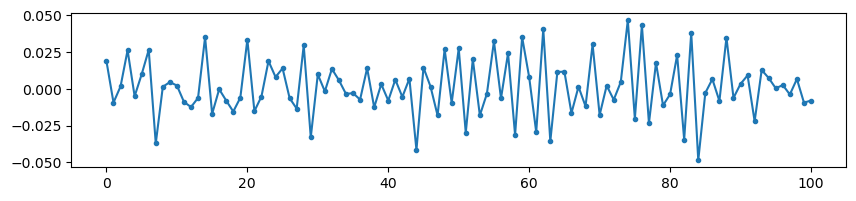

In [230]:
fig,ax= subplots(figsize=(10,2))
η = ηrange[1]
d = data[data.η .== η,:]
d = data[data.nux .== nuxrange[2],:]
d = data[data.ω0 .== ω0range[15],:]

ax.plot(d.z0[100:200],".-")
fig

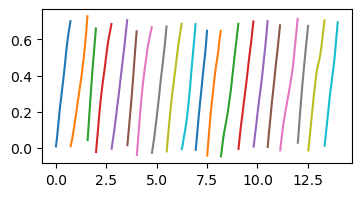

In [231]:
dt = 0.01
T = 10000
ν0 = 1/log(2)
vz = 0.001
η = 1
ω0=3.01
nux =6.
# Set model-specific parameters
bz = -ω0^2
a = ω0*η
σ = sqrt(vz*a*ω0^2) # variance of noise in z
A = [-a 0.0; 0.0 -a]
Γ = [σ 0.0; 0.0 σ]
uz = [1.0,0.0]
bz = [bz, 0.0]
nuxv = zeros(2)
nuxv[1] = nux
Cθ = zeros(2,2)
b̃θ = zeros(2)
params = (A,bz,b̃θ,uz,nuxv,Cθ,Γ,ν0)
init = [0.0, 0.0, 0.0, 0.0]
df = make_sim_df(init, params, dt, T)
df.ω0 .= ω0
df.η .= η
df.y = df.z .+ log(2)*df.θ  # y = z + log(2) * θ
fig,ax = subplots(figsize=(4,2))
for cell in (df.cell |> unique)[1:20]
    df_cell = df[df.cell .== cell, :]
    ax.plot(df_cell.time, df_cell.y, "-", label="z")
end
fig

In [152]:
# check we are getting physical solutions
dfu = data[data.nux .== nuxrange[1],:]
P = hcat([[d.isphys[1] for d in groupby(dfuet, :η)] for dfuet in groupby(dfu, :ω0)]...)
minimum(P) # should be 1

0

In [153]:
P

4×26 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

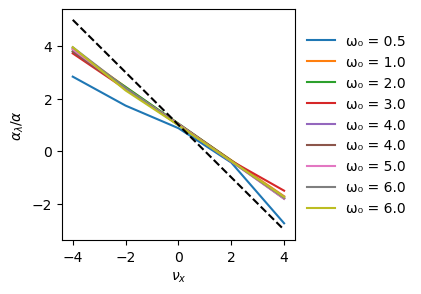

In [154]:
fig,axs = subplots(figsize=(3, 3),sharex=true)

ax = axs #[0]
η =  ηrange[end]
j = 0
for ω0 in ω0range[2:3:end]
    df = data[(data.η .== η) .& (data.ω0 .== ω0), :]
    α = [-cov(d.ϕ, d.z0) / var(d.z0) for d in groupby(df, :nux)]
    αλ = [-cov(d.ϕ ./ d.τ, d.z0) / var(d.z0) * mean(d.τ) for d in groupby(df, :nux)]
    ax.plot(nuxrange,αλ ./α,"C$(j)-",label = "ω₀ = $(round(ω0; sigdigits=1))")
    j = j+ 1
end
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5),frameon=false)
#ax.set_ylim([0,1.2])
#ax.legend()
#ax.set_xlim([0,1])
#ax.set_ylim([0,1])
ax.plot(nuxrange,1 .- nuxrange,"k--")
ax.set_ylabel("\$\\alpha_{\\lambda}/\\alpha \$")

# ax = axs[1]
# η =  ηrange[end]
# j = 0
# for ω0 in ω0range[10:10:end]
#     df = data[(data.η .== η) .& (data.ω0 .== ω0), :]
#     ρ = [-cov(d.λ[2:end], d.λ[1:end-1]) / var(d.λ) for d in groupby(df, :q)]
#     ax.plot(qrange,ρ,"C$(j)-",label="ω0 = $(ω0)")
#     j = j+ 1
# end

ax.set_xlabel(L"$\nu_x$")
fig

# Coarse-grained paramaters (Fig 3 A)

In [245]:
# get theoretical predictions


ω0range_ = collect(ω0range[1]:0.05:ω0range[end])
ηrange_ = ηrange
l =20
C = zeros(length(ω0range_), length(ηrange_))
Ws = zeros(length(ω0range_), length(ηrange_),l)
Ss = zeros(length(ω0range_), length(ηrange_))
Ks = zeros(length(ω0range_), length(ηrange_), l, l)

for i in 1:length(ω0range_)
    for j in 1:length(ηrange_)
        ω0 = ω0range_[i]
        η = ηrange_[j]
        K = [ksho(abs(ii-jj)*log(2), η/2, ω0) for ii in 1:l, jj in 1:l]
        # condition number
        C[i,j] = cond(K)

        k_l = [ksho(abs(j)*log(2), η/2, ω0) for j in 1:l]
        ch = cholesky(Symmetric(K); check=false)  # robust if κ is only semidefinite
        wl = ch \ k_l
        σ2 = ksho(0.0, η, ω0) - dot(k_l, wl)
        Ws[i,j,:] = wl
        Ss[i,j] = σ2
        Ks[i,j,:,:] = K

    end
end


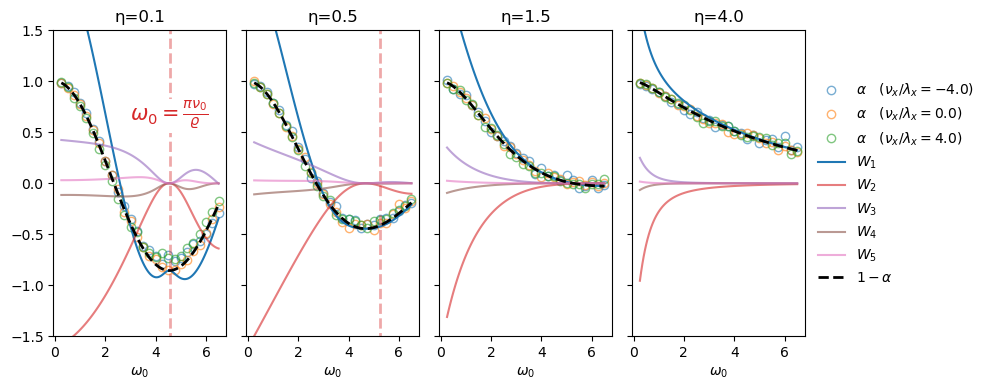

In [247]:
include("model.jl")
include("formulas.jl")

fig, axs = subplots(figsize=(10, 4), ncols=length(ηrange),  sharey="row", sharex=true)
for i in 1:length(ηrange)
    ax = axs[i-1]

    η = ηrange[i]

    for j in 1:2:length(nuxrange)
        dfcell = data[(data.η .== η) .& (data.nux .== nuxrange[j]), :]
        alphas = [-cov(df.ϕ, df.z0) / var(df.z0) for df in groupby(dfcell, :ω0)]
        ax.plot(ω0range, 1 .-alphas, "o", label="\$\\alpha \\quad({\\nu_{x}/\\lambda_x}=$(nuxrange[j]))\$",fillstyle="none",alpha=0.6)
    end


    ax.plot(ω0range_,Ws[:,i,1], "C0-",label= L"$W_{1}$")
    for k in 2:5
        ω0 = ω0range_[k]
        ax.plot(ω0range_, Ws[:,i,k], "-",alpha=0.6,label= "\$W_{$(k)}\$")
    end
    #ax.plot([0],[0],"C0-",alpha=0.3,label= L"$W_{i},i>1$")


    ax.plot(ω0range_, [ksho(log(2),η/2, ω0range_[i])/ksho(0.0, η/2, ω0range_[i]) for i in 1:length(ω0range_)], "k--",label=L"$1-\alpha$",lw=2)
    
    #ax.set_ylim([-10,10])
    ax.set_xlabel(L"$\omega_0$")
    ax.set_title("η=$(η)")
    ax.set_ylim([-1.5,1.5])
end
axs[0].vlines(π/log(2)/sqrt(abs.(1-ηrange[1]^2)), ymin=-2, ymax=2, colors="C3", linestyles="--", lw=2,alpha=0.4, label=L"$\omega_0 = \frac{\pi}{\log(2)\sqrt{|1-\eta^2|}}$")
# make text over the line

# make the text have white background
axs[0].text(π/log(2)/sqrt(abs.(1-ηrange[1]^2)), 0.5, L"$\omega_0 = \frac{\pi \nu_0}{\varrho}$", color="C3", ha="center", va="bottom", 
fontsize=15, bbox=Dict("facecolor"=>"white", "edgecolor"=>"none", "pad"=>0.5))
axs[1].vlines(π/log(2)/sqrt(abs.(1-ηrange[2]^2)), ymin=-2, ymax=2, colors="C3", linestyles="--", lw=2,alpha=0.4)
axs[3].legend(frameon=false, loc="center left", bbox_to_anchor=(1, 0.5))
savefig(joinpath(FIG_PATH, "fig4.pdf"), bbox_inches="tight", pad_inches=0.1, format="pdf")
tight_layout()
fig

## Contour plot

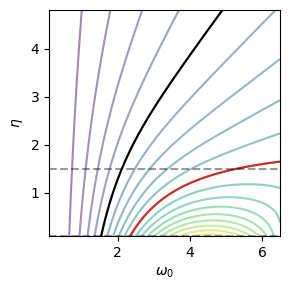

In [244]:
include("formulas.jl")
ηrange_ = collect(0.1:0.02:1.2ηrange[end])
ω0range_ = collect(0.1:0.02:ω0range[end])

# Preallocate
alpha_vals = zeros(length(ω0range_), length(ηrange_))
alpha2_vals = zeros(length(ω0range_), length(ηrange_))
Ws_vals = zeros(length(ω0range_), length(ηrange_),l)

# Populate the matrix
for (i, ω0) in enumerate(ω0range_)
    for (j, η) in enumerate(ηrange_)
        alpha_vals[i, j] = alpha_SHO(η * ω0, ω0, 1 / log(2), η)
        alpha2_vals[i, j] = 1-ksho(log(2), η/2, ω0) / ksho(0.0, η/2, ω0)
    end
end

# Transpose for correct orientation in PyPlot
alpha_vals_t = alpha_vals'

# Set contour levels
vmin = minimum(alpha_vals_t)
vmax = maximum(alpha_vals_t)
levels = range(vmin, vmax, length=20)

# Plot
fig, ax = subplots(figsize=(3, 3))


cs = ax.contour(ω0range_,ηrange_,alpha_vals_t,levels=20,alpha=0.5)
cs = ax.contour(ω0range_,ηrange_,alpha_vals_t,levels=[0.5], colors="k", linewidths=1.5, linestyles="-")
cs = ax.contour(ω0range_,ηrange_,alpha_vals_t,levels=[1.0], colors="C3", linewidths=1.5, linestyles="-")
#ax.clabel(cs,cs.levels, inline=true, fontsize=8)
#ax.semilogy()

ax.plot(ω0range_, ones(length(ω0range_))*ηrange[1], "k--",alpha=0.4)
#ax.plot(ω0range_, ones(length(ω0range_))*ηrange[2], "k--",alpha=0.4)
ax.plot(ω0range_, ones(length(ω0range_))*ηrange[3], "k--",alpha=0.4)

# Label contours


# Labels and title
ax.set_xlabel(L"\omega_0")
ax.set_ylabel(L"\eta")
savefig(joinpath(FIG_PATH, "fig2_contour.pdf"), bbox_inches="tight", pad_inches=0.1, format="pdf")
tight_layout()
fig